In [1]:
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.io import fits
from astropy.time import Time
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.data import (
    DataStore,
    FixedPointingInfo,
    Observation,
    observatory_locations,
)
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import MapDatasetMaker
from gammapy.maps import MapAxis, WcsGeom
from gammapy.modeling.models import (
    ExpDecayTemporalModel,
    FoVBackgroundModel,
    Models,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
    TemplateSpatialModel,
    EBLAbsorptionNormSpectralModel,
    TemplateSpectralModel
)
from gammapy.catalog import CATALOG_REGISTRY
from astropy.io import ascii

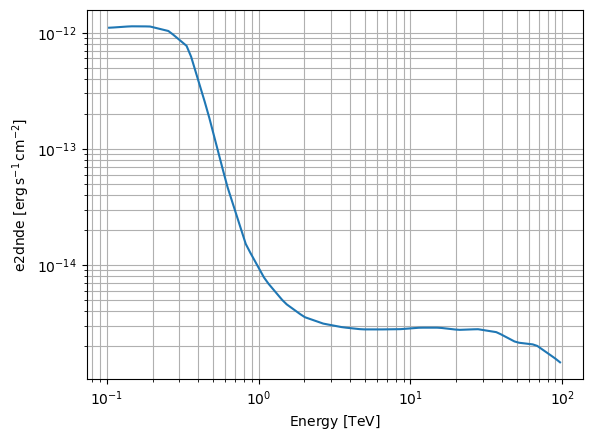

In [2]:
# Source
target_position = SkyCoord(40.669 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg")

# Template spectral model. Defined by custom tabular values from Inoue+ 2022
data = ascii.read("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Wind/Inoue_2022_wind.dat")

data['Frequency[Hz]'] = 10**data['logFrequency[Hz]'] 
data['flux[ergcm^-2s^-1]'] = 10**data['logflux[ergcm^-2s^-1]']

energy = data['Frequency[Hz]'] * u.Hz
values = data['flux[ergcm^-2s^-1]'] *u.erg / (u.cm **2.0 * u.s)

energy_MeV = energy.to(u.MeV, equivalencies=u.spectral())

values = values.to(u.MeV / (u.cm ** 2.0 * u.s))
values_MeV = values / energy_MeV**2  # divide by energy to get dN/dE

spectral_model = TemplateSpectralModel(energy=energy_MeV, values=values_MeV)

spatial_model = PointSpatialModel.from_position(target_position)

sky_model = SkyModel(
                    spectral_model=spectral_model,
                    spatial_model=spatial_model,
                    name="NGC_1068",
                    )

# Background
bkg_model = FoVBackgroundModel(dataset_name="my-dataset")

# Plotting the model
energy_bounds = [0.1, 100] * u.TeV
opts = dict(sed_type="e2dnde", yunits=u.Unit("erg cm-2 s-1"))
spectral_model.plot(energy_bounds, **opts)
plt.grid(which="both")

In [3]:
# Define the full model
models = Models([sky_model, bkg_model])
print(models)

# save it to disk
file_model = "./Wind_NGC_1068.yaml"
models.write(file_model, write_covariance=False, overwrite=True)

irf_filename = "/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits"  
IRF = load_irf_dict_from_file(irf_filename)

# this is a dictionary with the IRF extensions:
IRF

Models

Component 0: SkyModel

  Name                      : NGC_1068
  Datasets names            : None
  Spectral model type       : TemplateSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    lon_0                         :     40.669   +/-    0.00 deg         
    lat_0                         :     -0.013   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         




{'aeff': <gammapy.irf.effective_area.EffectiveAreaTable2D at 0x13698c250>,
 'psf': <gammapy.irf.psf.parametric.EnergyDependentMultiGaussPSF at 0x164f4b310>,
 'edisp': <gammapy.irf.edisp.core.EnergyDispersion2D at 0x164f58cd0>,
 'bkg': <gammapy.irf.background.Background3D at 0x164338c50>}

In [4]:
livetime = 11 * u.hr              #observation time with units
obs_id = "0001"                   # obs_id could be everything

pointing = FixedPointingInfo(
    fixed_icrs=SkyCoord(40.169 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg"),
)

location = observatory_locations["cta_north"]

reference_time = Time("2026-05-28T00:00:00", format="isot", scale="utc")
observation = Observation.create(
                        obs_id=obs_id, 
                        pointing=pointing, 
                        livetime=livetime, 
                        irfs=IRF,
                        location=location,
                        reference_time = reference_time, 
                        tstart = 30 * u.min
              )                                   
print(observation)

Observation

	obs id            : 0001 
 	tstart            : 61188.02
	tstop             : 61188.48
	duration          : 39600.00 s
	pointing (icrs)   : 40.2 deg, -0.0 deg

	deadtime fraction : 0.0%



In [5]:
#Ereco ed Etrue must to be different: Etrue must have a larger range in order to reconstruct in the correct way (knowledge of
#the whole photon energy extension)

energy_axis = MapAxis.from_energy_bounds(
    "0.1 TeV", "100 TeV", nbin=10, per_decade=True
    )

# for the Edisp
energy_axis_true = MapAxis.from_energy_bounds(
    "0.01 TeV", "200 TeV", nbin=20, per_decade=True, name="energy_true"
    )

migra_axis = MapAxis.from_bounds(
    0.5, 2, nbin=150, node_type="edges", name="migra" #If node_type = ‘edge’ then bounds correspond to the lower
                                                      #  and upper bound of the first and last bin.
    )    

# let's define the geometry of the simulation:
geom = WcsGeom.create(
    skydir=pointing.fixed_icrs,           
    width=(4, 4),         # gammapy uses a square not a circle 
    binsz=0.02,           # pixel size
    frame="icrs",
    axes=[energy_axis],    #in reco energy
)
print(geom)

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (np.int64(200), np.int64(200), 30)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 40.2 deg, -0.0 deg
	width      : 4.0 deg x 4.0 deg
	wcs ref    : 40.2 deg, -0.0 deg



In [6]:
#### MapDataset object with zer0-filled map
empty = MapDataset.create(
        geom,                               
        energy_axis_true=energy_axis_true,       #for the IRF maps
        migra_axis=migra_axis,                   #for the Edisp map
        name="my-dataset",                       #the name that will read the FoVBKG
            )

### Make maps for a single observation
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"]) #which maps to make (by default all)
dataset = maker.run(empty, observation)    #object

dataset.models = models

print(dataset)

MapDataset
----------

  Name                            : my-dataset 

  Total counts                    : 0 
  Total background counts         : 545183.17
  Total excess counts             : -545183.17

  Predicted counts                : 545562.73
  Predicted background counts     : 545183.17
  Predicted excess counts         : 379.56

  Exposure min                    : 3.46e+05 m2 s
  Exposure max                    : 6.63e+10 m2 s

  Number of total bins            : 1200000 
  Number of fit bins              : 1200000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 1091125.45

  Number of models                : 2 
  Number of parameters            : 5
  Number of free parameters       : 3

  Component 0: SkyModel
  
    Name                      : NGC_1068
    Datasets names            : None
    Spectral model type       : TemplateSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
    

In [7]:
#define the seed of random number generator 
seed=0

#simulate
sampler = MapDatasetEventSampler(random_state=seed)
events = sampler.run(dataset, observation)

The meta information will be empty here.


In [8]:
events.table

TIME,ENERGY_TRUE,RA_TRUE,DEC_TRUE,ENERGY,RA,DEC,MC_ID,EVENT_ID,DETX,DETY
s,TeV,deg,deg,TeV,deg,deg,,,deg,deg
float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64
1799.9999999999984,0.453016521860981,42.050839346947896,0.18711020457335237,0.453016521860981,42.050839346947896,0.18711020457335237,0,473243,1.881840789477548,0.20010319333923568
1799.9999999999984,0.17008210616816555,39.908607020188434,0.27718978872191447,0.17008210616816555,39.908607020188434,0.27718978872191447,0,119480,-0.2603932723435041,0.2901896544681812
1799.9999999999984,0.16708186620087645,41.61814969568452,0.4619297711452117,0.16708186620087645,41.61814969568452,0.4619297711452117,0,3671,1.4491523836127966,0.4749256132624298
1799.9999999999984,0.11092104042691746,40.646685463822344,1.1307510589810457,0.11092104042691746,40.646685463822344,1.1307510589810457,0,336252,0.4776876153620477,1.1437506071754766
1799.9999999999984,0.5372401333850603,41.567499365869885,0.464801220171861,0.5372401333850603,41.567499365869885,0.464801220171861,0,202174,1.3985019757720054,0.4777973478461093
1799.9999999999984,0.5130502801112505,39.75765425448471,-1.4483699806744785,0.5130502801112505,39.75765425448471,-1.4483699806744785,0,491751,-0.41134339632623945,-1.4353703156998998
1799.9999999999984,0.1468440811822803,39.85217147497128,0.6574980321693249,0.1468440811822803,39.85217147497128,0.6574980321693249,0,273931,-0.31682935814744007,0.6704978334149603
1799.9999999999984,0.12225925272488661,39.356717619372965,-1.9456240289453843,0.12225925272488661,39.356717619372965,-1.9456240289453843,0,272201,-0.8122761409731171,-1.932625335331464


In [9]:
print(f"Source events: {(events.table['MC_ID'] == 1).sum()}")
print(f"Background events: {(events.table['MC_ID'] == 0).sum()}")

Source events: 399
Background events: 544697


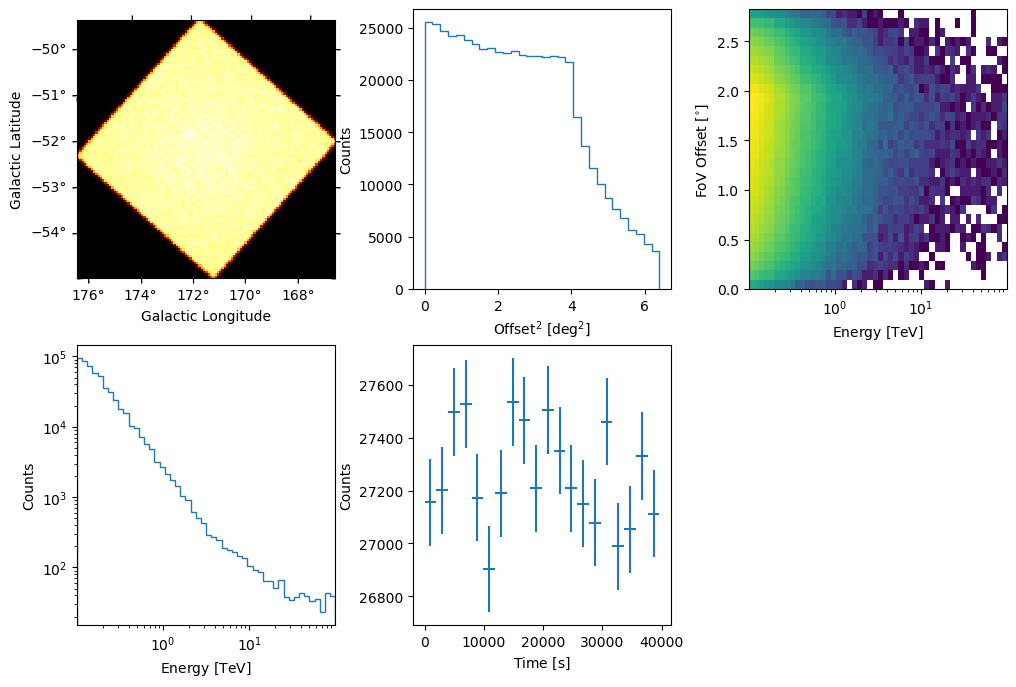

In [10]:
# let's have a look at the events
events.peek()
#counts map

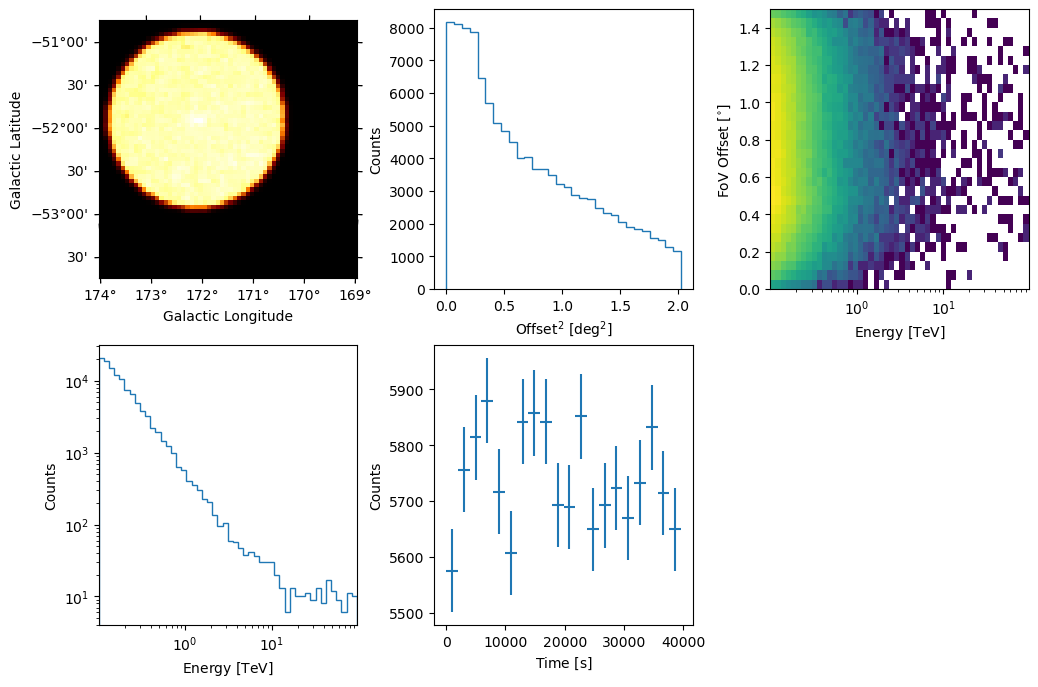

In [11]:
#We are focusing on our source
src_pos = SkyCoord(40.669 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg")

#region_sky = CircleSkyRegion(center=src_pos, radius=0.3 * u.deg)
region_sky = CircleSkyRegion(center=src_pos, radius=1 * u.deg)
evt = events.select_region(region_sky)
evt.peek()

In [12]:
# save the data into a fits file 
observation.events = events
observation.write("source_evt.fits", include_irfs=False, overwrite=True)